# Figures from the paper

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## ABX

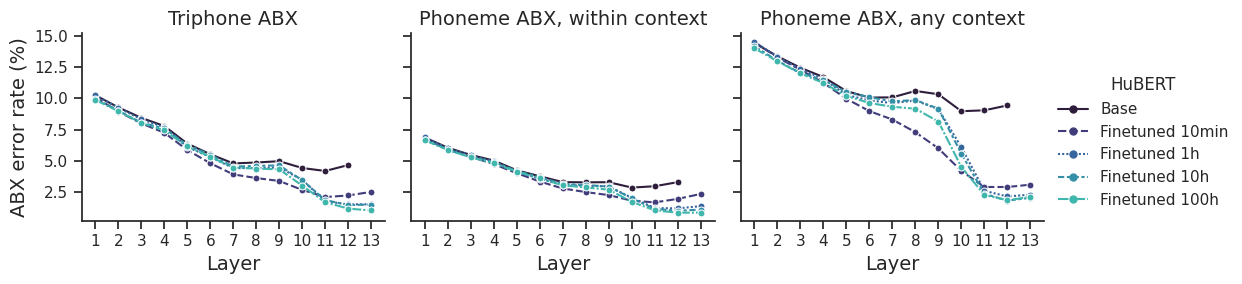

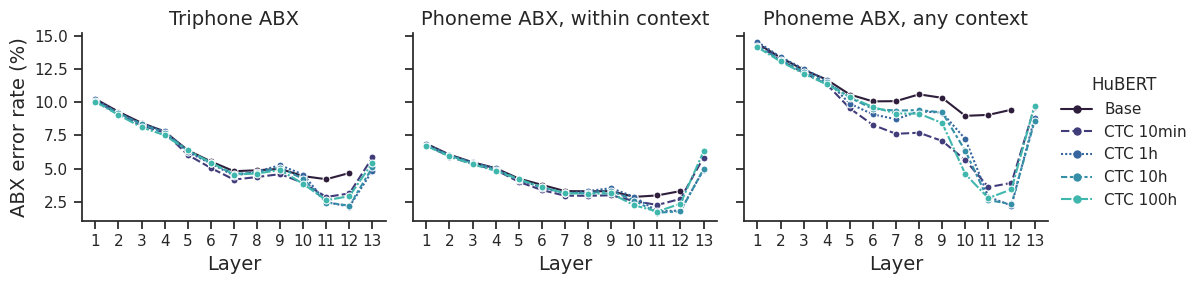

In [2]:
abx = pd.read_csv("../results/abx.csv")
abx["score"] *= 100
abx["figure"] = abx.apply(
    lambda row: f"Phoneme ABX, {row['context_mode']} context" if row["item"].startswith("phoneme") else "Triphone ABX",
    axis=1,
)
abx["label"] = abx["model"].map(
    {
        "hubert_base": "Base",
        "hubert_frame10min": "Finetuned 10min",
        "hubert_frame1h": "Finetuned 1h",
        "hubert_frame10h": "Finetuned 10h",
        "hubert_frame100h": "Finetuned 100h",
        "hubert_ctc10min": "CTC 10min",
        "hubert_ctc1h": "CTC 1h",
        "hubert_ctc10h": "CTC 10h",
        "hubert_ctc100h": "CTC 100h",
    }
)
abx = abx.dropna()

groups = [
    ["Base", "Finetuned 10min", "Finetuned 1h", "Finetuned 10h", "Finetuned 100h"],
    ["Base", "CTC 10min", "CTC 1h", "CTC 10h", "CTC 100h"],
]

sns.set_theme(
    context="notebook",
    style="white",
    palette="mako",
    rc={"axes.labelsize": 14, "xtick.bottom": True, "ytick.left": True},
)
for labels in groups:
    grid = sns.relplot(
        abx[abx["label"].isin(labels)],
        x="layer",
        y="score",
        col="figure",
        hue="label",
        style="label",
        col_order=["Triphone ABX", "Phoneme ABX, within context", "Phoneme ABX, any context"],
        hue_order=labels,
        style_order=labels,
        aspect=1.2,
        height=3,
        kind="line",
        marker="o",
        markersize=5,
        errorbar=None,
        legend=True,
    )
    grid.legend.set_title("HuBERT")
    grid.set_axis_labels("Layer", "ABX error rate (%)")
    grid.set_titles("{col_name}")
    grid.set(xticks=range(1, 14))
    plt.show()

## MCD by style

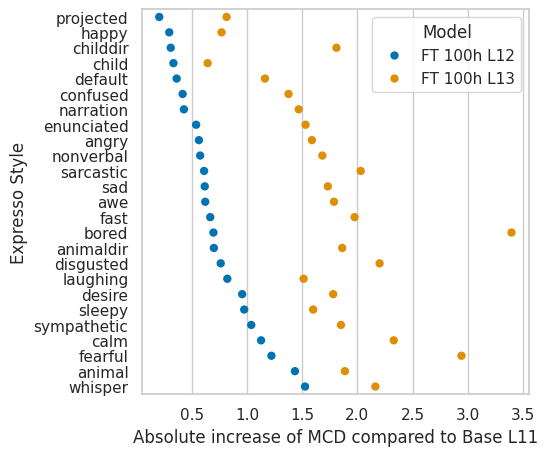

In [3]:
df = pd.read_csv("../results/mcd.csv")
df["is_read"] = df["style"].str.startswith("read-")
df["is_conv"] = df["style"].str.startswith("conv-")
df["style"] = df["style"].str.removeprefix("read-").str.removeprefix("conv-")

relative = {"style": [], "layer": [], "score": []}
absolute = {"style": [], "layer": [], "score": []}
for style in df["style"].unique():
    y = df[(df["style"] == style) & (df["layer"] == 11)]
    for layer in [12, 13]:
        x = df[(df["style"] == style) & (df["layer"] == layer)]
        score = x["score"].mean() - y["score"].mean()
        relative["style"].append(style)
        relative["layer"].append(layer)
        relative["score"].append((score / y["score"].mean()) * 100)
        absolute["style"].append(style)
        absolute["layer"].append(layer)
        absolute["score"].append(score)
relative = pd.DataFrame(relative)
absolute = pd.DataFrame(absolute)
mean = df.groupby(["style", "layer"], as_index=False)["score"].mean()

sns.set_theme(context="notebook", style="whitegrid")
fig, ax = plt.subplots(figsize=(5, 5))
sns.stripplot(
    data=absolute,
    x="score",
    y="style",
    order=absolute[absolute.layer == 12].sort_values(by="score")["style"],
    hue="layer",
    hue_order=[12, 13],
    dodge=False,
    jitter=False,
    orient="h",
    palette="colorblind",
    s=6,
    ax=ax,
)
sns.move_legend(
    ax,
    "upper right",
    title="Model",
    labels=["FT 100h L12", "FT 100h L13"],
)
ax.set_xlabel("Absolute increase of MCD compared to Base L11")
ax.set_ylabel("Expresso Style")
plt.show()

## Trade-off between LM and expressive resynthesis

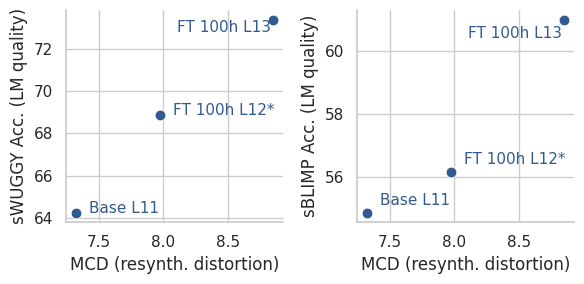

In [4]:
COLOR = (50 / 255, 90 / 255, 143 / 255)

mcd = pd.read_csv("../results/mcd.csv").groupby(["model", "layer"], as_index=False)["score"].mean()
mcd.index = mcd["model"] + " " + mcd["layer"].astype(str)
mcd = [
    mcd.loc["hubert_base 11"]["score"],
    mcd.loc["hubert_frame100h 12"]["score"],
    mcd.loc["hubert_frame100h 13"]["score"],
] * 2

slm = pd.read_csv("../results/slm.csv")
slm = slm[slm["mode"] == "test"].set_index("model")
slm = [
    slm.loc["base_l11_without_init"]["swuggy_all"],
    slm.loc["frame_l12_with_init"]["swuggy_all"],
    slm.loc["frame_l13"]["swuggy_all"],
    slm.loc["base_l11_without_init"]["sblimp"],
    slm.loc["frame_l12_with_init"]["sblimp"],
    slm.loc["frame_l13"]["sblimp"],
]

df = pd.DataFrame(
    {
        "model": ["Base L11", "FT 100h L12", "FT 100h L13"] * 2,
        "mcd": mcd,
        "slm": slm,
        "metric": (["sWUGGY"] * 3) + (["sBLIMP"] * 3),
    }
)
sns.set_theme(context="notebook", style="whitegrid")
grid = sns.FacetGrid(data=df, col="metric", col_order=["sWUGGY", "sBLIMP"], sharey=False)
grid.set_axis_labels()
grid.map(sns.scatterplot, "mcd", "slm", s=60, color=COLOR)
grid.axes[0, 0].set_ylabel("sWUGGY Acc. (LM quality)")
grid.axes[0, 1].set_ylabel("sBLIMP Acc. (LM quality)")
grid.axes[0, 0].annotate("Base L11", (df.iloc[0]["mcd"] + 0.1, df.iloc[0]["slm"]), fontsize=11, color=COLOR)
grid.axes[0, 0].annotate("FT 100h L12*", (df.iloc[1]["mcd"] + 0.1, df.iloc[1]["slm"]), fontsize=11, color=COLOR)
grid.axes[0, 0].annotate("FT 100h L13", (df.iloc[2]["mcd"] - 0.75, df.iloc[2]["slm"] - 0.6), fontsize=11, color=COLOR)
grid.axes[0, 1].annotate("Base L11", (df.iloc[3]["mcd"] + 0.1, df.iloc[3]["slm"] + 0.25), fontsize=11, color=COLOR)
grid.axes[0, 1].annotate("FT 100h L12*", (df.iloc[4]["mcd"] + 0.1, df.iloc[4]["slm"] + 0.25), fontsize=11, color=COLOR)
grid.axes[0, 1].annotate("FT 100h L13", (df.iloc[5]["mcd"] - 0.75, df.iloc[5]["slm"] - 0.6), fontsize=11, color=COLOR)

grid.set_titles("")
grid.set_xlabels("MCD (resynth. distortion)")
grid.tight_layout()
plt.show()